In [5]:
import pandas as pd
import numpy as np
import os
import pickle
# 주피터 셀 실행 단계에서 다양한 이유로 경고(warning)문이 발생하는데, 셀 싱행에는 영향을 미치지 않으므로 경고문구가 생기지 않도록 설정.
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import random
import math
from tqdm import tqdm

import numpy as np
import pandas as pd

import pickle

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns 
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  

In [13]:
# 최종 데이터 불러오기 
solar_data = pd.read_csv('F:/2.프로젝트/[BMT] 수요 맞춤형AI/[태양광 발전량] 데이터/solar_hour_2025-06-04.csv')
weather_data = pd.read_csv('F:/2.프로젝트/[BMT] 수요 맞춤형AI/[태양광 발전량] 데이터/부산기상데이터.csv',encoding='cp949')

In [15]:
# 왜도, box plot 그리는 함수 
def box_kde_plot(data, colum):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))  # 1행 2열, 가로 크기 조절

    # 2. KDE (Kernel Density Estimate)
    sns.kdeplot(data[colum], shade=True, color='purple',ax = axes[0])
    axes[0].set_title("Kernel Density Estimation (KDE)")

    # 3. Boxplot
    sns.boxplot(data[colum], color='orange',ax = axes[1])
    axes[1].set_title("Boxplot of Data")

In [16]:
# IQR 이상치 제거 
def IQR_drop(data, value):
    # IQR 계산
    Q1 = data[value].quantile(0.25)  # 1사분위수
    Q3 = data[value].quantile(0.75)  # 3사분위수
    IQR = Q3 - Q1                      # IQR

    # 이상치 기준 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치 제거
    filtered_data = data[(data[value] >= lower_bound) & (data[value] <= upper_bound)]
    
    return filtered_data

# 이상치 Clipped

def IQR_Clipping(df,value):
    # 평균과 표준편차 계산
    mean = df[value].mean()
    std = df[value].std()

    # 3σ 범위 설정
    lower_bound = mean - (3 * std)
    upper_bound = mean + (3 * std)

    # 이상치 제거 (Clipping)
    clipp_data = df[value].clip(lower_bound, upper_bound)

    return clipp_data


In [23]:
def data_eda(solar_data, weather_data, id ):
    raw_data = solar_data.loc[solar_data['id']==id] # id 1인 애들만 가져오기 
    raw_data = raw_data.dropna().reset_index(drop=True) # 결측 데이터 삭제 
    raw_data['ymdhms'] = pd.to_datetime(raw_data['ymdhms'])
    
    w_data = weather_data[['일시','강수량(mm)','기온(°C)','습도(%)','일사(MJ/m2)','일조(hr)','풍속(m/s)']]
    w_data.fillna(0, inplace=True)
    weather = w_data.loc[(w_data['일시'] >= '2024-01-23 11:00')&(w_data['일시'] <= '2025-06-04 08:00')].reset_index(drop=True)
    weather.columns = ['ymdhms', '강수량(mm)', '기온(°C)', '습도(%)', '일사(MJ/m2)', '일조(hr)', '풍속(m/s)']
    weather['ymdhms'] = pd.to_datetime(weather['ymdhms'])

    
    # 부산 일사량 데이터 결합
    merged_df = pd.merge(raw_data, weather, on='ymdhms', how='left')    
    df = merged_df.copy()
    
    df['Hour'] = df.ymdhms.dt.hour

    
    # 데이터 전처리 
    #### generate_gap ####
    # 0이 연속적으로 유지되는 구간 탐지
    threshold = 30  # 연속으로 유지되는 최소 횟수
    is_zero = df['generate_gap'] == 0  # 값이 0인 위치를 True로 표시
    zero_group = is_zero.astype(int).groupby(is_zero.ne(is_zero.shift()).cumsum()).cumsum()  # 연속 카운트
    
    # 조건 만족하는 구간 추출
    long_zero_indices = df.index[zero_group >= threshold]
    df = df.drop(long_zero_indices,axis=0).reset_index(drop=True)
    df.loc[df.Hour == 0 , 'generate_gap'] = 0
    df = df.drop(df.loc[df['generate_gap'] <= 0].index).reset_index(drop=True)
    
    df = IQR_drop(df,'generate_gap')
    df = IQR_drop(df,'Accumulated_Generation')
    #df['generate_gap'] = IQR_Clipping(df,'generate_gap')

    
    #### Accumulated_Generation ####
    #df['Accumulated_Generation'] =df['Accumulated_Generation'].mask(df['Accumulated_Generation'] <= 1).ffill()
    
    df_filled = df.fillna(method='bfill')
    
    #box_kde_plot(df, 'generate_gap')

    return df_filled


In [26]:
# 데이터를 저장할 딕셔너리
dataframes = {}

# for문을 이용해 CSV 파일을 읽어 각각 다른 이름으로 저장
for i in range(1,19):
    df_name = f"data_{i}"  # 변수 이름 자동 생성 (df_1, df_2, df_3)
    dataframes[df_name] = data_eda(solar_data, weather_data, i)
    print(df_name,":" , len(dataframes[df_name]))


data_1 : 5031
data_2 : 5058
data_3 : 5046
data_4 : 5044
data_5 : 5062
data_6 : 5046
data_7 : 4986
data_8 : 5041
data_9 : 4980
data_10 : 4939
data_11 : 5029
data_12 : 4464
data_13 : 4721
data_14 : 4652
data_15 : 4668
data_16 : 4731
data_17 : 4727
data_18 : 4694


<Axes: >

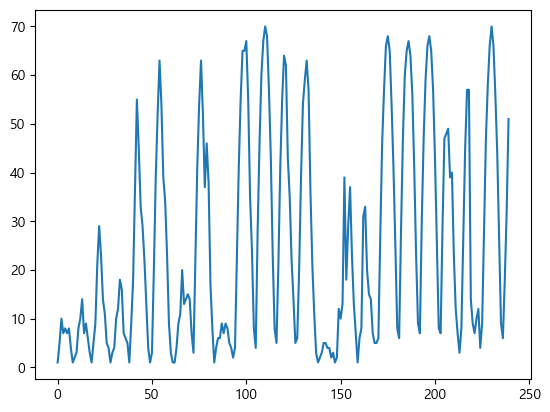

In [29]:
dataframes['data_1'][:240].generate_gap.plot()

#### MODEL

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, Flatten,BatchNormalization,  Dropout, LSTM, Bidirectional,GRU,TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten


In [8]:
"""
8. LSTM
"""

import tensorflow as tf

# 어텐션 레이어 정의
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # 어텐션 가중치 계산
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # 가중 평균 계산
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

    def get_config(self):
            config = super().get_config()
            config.update({
                "W1": self.W1,
                "W2": self.W2,
                "V": self.W2,
            })
            return config


def create_LSTM_model(input_shape, output_shape, units=50):
    # 모델 구조 정의
    model = Sequential()
    model.add(LSTM(units, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units, activation='tanh', return_sequences=False))
    model.add(Dense(output_shape))
    return model
    
def Bidirectional_LSTM_model(input_shape, output_shape, units=50):
    # 모델 구조 정의
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation='tanh', return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(units, activation='tanh', return_sequences=False)))
    model.add(Dense(output_shape))

    return model
    
def create_attention_model1(input_shape, output_shape, units=50):
    inputs = tf.keras.layers.Input(shape=input_shape)
    lstm1 = tf.keras.layers.LSTM(units=units, return_sequences=True, activation='tanh')(inputs)
    lstm2 = tf.keras.layers.LSTM(units=units, return_sequences=True, activation='tanh')(lstm1)

    context_vector1, attention_weights1 = Attention(10)(lstm1, lstm2)
    context_vector2, attention_weights2 = Attention(10)(lstm2, lstm1)

    concatenated_vector = tf.keras.layers.Concatenate(axis=-1)([context_vector1, context_vector2])

    outputs = tf.keras.layers.Dense(units=output_shape)(concatenated_vector)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

def create_attention_model(input_shape, output_shape, units=50):
    inputs = tf.keras.layers.Input(shape=input_shape)
    lstm1 = tf.keras.layers.LSTM(units=units, return_sequences=True, activation='tanh')(inputs)
    lstm2 = tf.keras.layers.LSTM(units=units, return_sequences=True, activation='tanh')(lstm1)
    lstm3 = tf.keras.layers.LSTM(units=units, return_sequences=True, activation='tanh')(lstm2)
    lstm4 = tf.keras.layers.LSTM(units=units, return_sequences=True, activation='tanh')(lstm3)

    context_vector1, attention_weights1 = Attention(10)(lstm3, lstm4)
    context_vector2, attention_weights2 = Attention(10)(lstm4, lstm3)

    concatenated_vector = tf.keras.layers.Concatenate(axis=-1)([context_vector1, context_vector2])

    outputs = tf.keras.layers.Dense(units=output_shape)(concatenated_vector)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

def jyoung_model(input_shape, output_shape):
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape))
    LSTM_model.add(LSTM(32, activation='tanh',return_sequences=True))
    LSTM_model.add(Dropout(0.2))
    LSTM_model.add(LSTM(16, activation='tanh'))
    LSTM_model.add(Dense(output_shape))
    
    return LSTM_model
    

def cnn_lstm_model2(input_shape,output_shape):
    model = Sequential([

        Conv1D(filters=128, kernel_size=3, activation='tanh', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),

        # LSTM 레이어 추가 (더 깊은 시퀀스 학습 가능)
        LSTM(128, return_sequences=True),
        
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32, return_sequences=True),
        Dropout(0.2),
        LSTM(16, return_sequences=False),  # 마지막 LSTM
        
        # Fully Connected Layers (더 깊고 복잡한 학습 가능)
        Dense(64, activation='tanh'),
        Dense(32, activation='tanh'),
        Dense(16, activation='tanh'),
        Dense(output_shape)])
    
    return model

def cnn_lstm_model3(input_shape,output_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dense(16, activation='tanh'),
        Dense(8, activation='tanh'),
        Dense(output_shape)
    ])
    
    return model


def multi_step_model(n_steps,n_features, output_shape): 
    multi_step_model = Sequential()

    # 1D CNN을 적용하여 특징 추출
    multi_step_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), 
                                        input_shape=(None, n_steps, n_features)))  # (Batch, Time Steps, n_steps, n_features)
    multi_step_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))  # CNN Pooling 적용
    multi_step_model.add(TimeDistributed(Flatten()))  # 1D 데이터를 Flatten

    # LSTM 레이어 추가
    multi_step_model.add(LSTM(16, return_sequences=True, activation='softsign'))  # Many-to-Many 구조
    multi_step_model.add(LSTM(8, activation='relu'))  # 마지막 LSTM

    # 출력 레이어 (24시간 예측)
    multi_step_model.add(Dense(output_shape))  # 24개의 연속된 시간대 예측

    return multi_step_model

In [9]:
"""
7. Create Sequential Dataset
"""

def create_dataset(data, features, target, past_history, future_target):
    # #1. Train, Test Split
    train_data = data[data.ymdhms < '2025-03-01 00:00:00']  # 2023년까지 Train 데이터
    valid_data = data[(data.ymdhms >= '2025-03-01 00:00:00')&(data.ymdhms < '2025-05-01 00:00:00')]  # 2024년 valid 데이터
    test_data = data[(data.ymdhms >= '2025-05-01 00:00:00')]  # 2024년 Test 데이터
    
    # 2. Train, Test 데이터 분리
    X_train = train_data[features]
    y_train = train_data[target].values
    
    X_valid = valid_data[features]
    y_valid = valid_data[target].values

    X_test = test_data[features]
    y_test = test_data[target].values

    #2. Create Scaler
    feature_scaler = MinMaxScaler()
    Scaled_X_train = feature_scaler.fit_transform(X_train)
    Scaled_X_valid = feature_scaler.transform(X_valid)
    Scaled_X_test = feature_scaler.transform(X_test)
    
    target_scaler = MinMaxScaler()
    Scaled_y_train = target_scaler.fit_transform(y_train.reshape(-1, 1))
    Scaled_y_valid = target_scaler.transform(y_valid.reshape(-1, 1)) # ⚠️ 문제점: X_valid에도 fit_transform()을 적용하면 train 기반 분포가 유지되지 않음 → transform()만 사용해야 함
    Scaled_y_test = target_scaler.transform(y_test.reshape(-1, 1))
    
    print("X_train & y_train's shape: {}, {}".format(Scaled_X_train.shape, Scaled_y_train.shape))
    print("X_valid & y_valid's shape: {}, {}".format(Scaled_X_valid.shape, Scaled_y_valid.shape))
    print("X_test & y_test's shape: {}, {}".format(Scaled_X_test.shape, Scaled_y_test.shape))
    
    #3. 각 데이터셋에 대해 Sequential Dataset 생성
    dataset_lst = [[Scaled_X_train, Scaled_y_train],[Scaled_X_valid, Scaled_y_valid],[Scaled_X_test, Scaled_y_test]]
    sequence_dataset_lst = []

    for dataset in dataset_lst:
        # print("dataset's shape: {}, {}".format(dataset[0].shape, dataset[1].shape))
        dataset_X, dataset_Y = [], []
        start_index = 0
        end_index = len(dataset[0]) - past_history - future_target + 1
    
        for i in range(start_index, end_index):
            past_end_index = i + past_history
            future_index = past_end_index + future_target
    
            # 과거 feature 데이터
            past_features = dataset[0][i:past_end_index]
    
            # 과거 target 데이터
            past_target = dataset[1][i:past_end_index]
    
            # 미래 target 데이터
            future_target_data = dataset[1][past_end_index:future_index]
    
            # X에 과거 feature와 target을 함께 추가
            X_sample = np.concatenate((past_features, past_target), axis=1)
            
            dataset_X.append(X_sample)
            dataset_Y.append(future_target_data)
            
        X_clean, Y_clean = remove_nan(np.array(dataset_X), np.array(dataset_Y))
        print(X_clean.shape, Y_clean.shape)
        sequence_dataset_lst.append([X_clean, Y_clean])

        
    return sequence_dataset_lst, feature_scaler, target_scaler

# X와 Y에서 NaN 값을 제거
def remove_nan(X, Y):
    if Y.ndim == 3:
        nan_indices = np.isnan(X).any(axis=(1, 2)) | np.isnan(Y).any(axis=(1, 2))
    else:
        nan_indices = np.isnan(X).any(axis=(1, 2)) | np.isnan(Y).any(axis=1)
    
    X_clean = X[~nan_indices]
    Y_clean = Y[~nan_indices]
    
    # Y가 3차원이 아닌 경우 3차원으로 변환
    if Y_clean.ndim == 2:
        Y_clean = np.expand_dims(Y_clean, axis=-1)
    
    return X_clean, Y_clean

In [10]:
df = dataframes['data_1'].copy()
target = 'generate_gap'

In [11]:
df.columns

Index(['id', 'ymdhms', 'YEAR', 'MONTH', 'DAY', 'PV_Volt', 'PV_Ampe', 'Volt_R',
       'Volt_S', 'Volt_T', 'Ampe_R', 'Ampe_S', 'Ampe_T', 'Frequency',
       'Today_Generate', 'Accumulated_Generation', 'generate_gap', '강수량(mm)',
       '기온(°C)', '습도(%)', '일사(MJ/m2)', '일조(hr)', '풍속(m/s)', 'Hour'],
      dtype='object')

In [12]:
# # 차분 변수 넣기 - Lag Feature 생성
# df['gap_t_1'] = df[target].shift(1)
# df['gap_t_2'] = df[target].shift(2)

In [13]:
# # Rolling statistics - 추세 반영/ 노이즈 제거 효과 
# df['gap_roll_mean3'] = df['generate_gap'].rolling(window=3).mean()
# df['gap_roll_std3']  = df['generate_gap'].rolling(window=3).std()

In [14]:
# 시간 변수 만들기 
# df['hour'] = df['ymdhms'].dt.hour
# df['weekday'] = df['ymdhms'].dt.weekday

# df['sin_day'] = np.sin(2 * np.pi * df['hour'] / 24)
# df['cos_day'] = np.cos(2 * np.pi * df['hour'] / 24)

# df['sin_week'] = np.sin(2 * np.pi * df['weekday'] / 7)
# df['cos_week'] = np.cos(2 * np.pi * df['weekday'] / 7)

In [15]:
#target log 변환 
df[target] = np.log10(df[target])

In [16]:
features = ['Ampe_R', 'Ampe_S','Ampe_T','일사(MJ/m2)','기온(°C)'] #'sin_day','cos_day', 'sin_week', 'cos_week']
target = 'generate_gap'

dataset_lst_1, feature_scaler_1, target_scaler_1 = create_dataset(df, features, target, 24, 1)
print("X_train: {} , y_train: {}".format(dataset_lst_1[0][0].shape, dataset_lst_1[0][1].shape))
print("X_valid: {} , y_valid: {}".format(dataset_lst_1[1][0].shape, dataset_lst_1[1][1].shape))
print("X_test: {} , y_test: {}".format(dataset_lst_1[2][0].shape, dataset_lst_1[2][1].shape))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train & y_train's shape: (3868, 5), (3868, 1)
X_valid & y_valid's shape: (715, 5), (715, 1)
X_test & y_test's shape: (448, 5), (448, 1)
(3844, 24, 6) (3844, 1, 1)
(691, 24, 6) (691, 1, 1)
(421, 24, 6) (421, 1, 1)
X_train: (3844, 24, 6) , y_train: (3844, 1, 1)
X_valid: (691, 24, 6) , y_valid: (691, 1, 1)
X_test: (421, 24, 6) , y_test: (421, 1, 1)


lstm

In [17]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [18]:
y_train_reshaped = dataset_lst_1[0][1].reshape(dataset_lst_1[0][1].shape[0], dataset_lst_1[0][1].shape[1])  # (3844, 1)
y_valid_reshaped = dataset_lst_1[1][1].reshape(dataset_lst_1[1][1].shape[0], dataset_lst_1[1][1].shape[1])  # (691, 1)
y_test_reshaped  = dataset_lst_1[2][1].reshape(dataset_lst_1[2][1].shape[0], dataset_lst_1[2][1].shape[1])     # (424, 1)

In [19]:
# model2 
input_shape=dataset_lst_1[0][0].shape[1:]
output_shape=y_train_reshaped.shape[1]

# cnn + lstm 
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(50, 3, activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(output_shape)
])

#  Bidirectional LSTM + Attention
# inputs = tf.keras.Input(shape=input_shape)
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True))(inputs)
# x = tf.keras.layers.Attention()([x, x])
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# outputs = tf.keras.layers.Dense(output_shape)(x)
# model = tf.keras.Model(inputs, outputs)

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Add, Dense

# def residual_lstm_model(input_shape, output_shape, units=64):
#     inputs = Input(shape=input_shape)  # (time_steps, n_features)

#     # 첫 번째 LSTM
#     x1 = LSTM(units, return_sequences=True, activation='tanh')(inputs)

#     # 두 번째 LSTM
#     x2 = LSTM(units, return_sequences=True, activation='tanh')(x1)

#     # Residual 연결 (x1 + x2)
#     x = Add()([x1, x2])  # shape must match

#     # 세 번째 LSTM → 마지막 출력을 위해 return_sequences=False
#     x = LSTM(units, activation='tanh', return_sequences=False)(x)

#     # 출력층
#     outputs = Dense(output_shape)(x)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model



In [62]:
# 모델 생성
#model = create_attention_model1(input_shape=dataset_lst_1[0][0].shape[1:], output_shape=y_train_reshaped.shape[1], units=64)
#model = residual_lstm_model(input_shape, output_shape, units=50)
model= create_LSTM_model(input_shape=dataset_lst_1[0][0].shape[1:], output_shape=y_train_reshaped.shape[1], units=64)
# 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 학습
history = model.fit(
    dataset_lst_1[0][0], y_train_reshaped,
    validation_data=(dataset_lst_1[1][0], y_valid_reshaped),
    epochs=500,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/500


241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0917 - mae: 0.2283 - val_loss: 0.0229 - val_mae: 0.1127
Epoch 2/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0220 - mae: 0.1117 - val_loss: 0.0159 - val_mae: 0.0894
Epoch 3/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0175 - mae: 0.0963 - val_loss: 0.0136 - val_mae: 0.0794
Epoch 4/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0149 - mae: 0.0853 - val_loss: 0.0128 - val_mae: 0.0744
Epoch 5/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0138 - mae: 0.0813 - val_loss: 0.0127 - val_mae: 0.0734
Epoch 6/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0132 - mae: 0.0789 - val_loss: 0.0125 - val_mae: 0.0725
Epoch 7/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0127 - mae: 0.0769 - val_loss: 0.0122 - val_mae: 0.0713
Epoch 8/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - mae: 0.0754 - val_loss: 0.0121 - val_mae: 0.0706
Epoch 9/500
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
예측 shape: (421, 1)


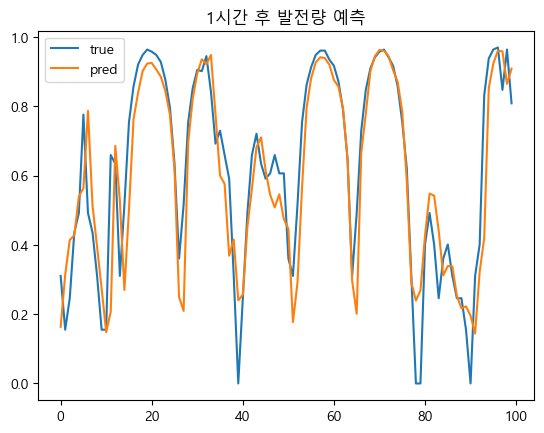

In [47]:
y_pred = model.predict(dataset_lst_1[2][0])
print("예측 shape:", y_pred.shape)  # (424, 1)

# 예: 첫 번째 시계열 예측 시각화
import matplotlib.pyplot as plt

plt.plot(y_test_reshaped[:100], label='true')
plt.plot(y_pred[:100], label='pred')
plt.legend()
plt.title("1시간 후 발전량 예측")
plt.show()

In [54]:
predict_result = pd.DataFrame()
predict_result['GT'] = np.squeeze(dataset_lst_1[2][1])
predict_result['Pred'] = y_pred 
predict_result

,GT,Pred
0,0.310417,0.163426
1,0.155209,0.313993
2,0.246000,0.414398
3,0.435726,0.427487
4,0.492000,0.539810
...,...,...
416,0.889022,0.842764
417,0.814523,0.816449
418,0.681725,0.704303
419,0.435726,0.405869


역변환 전

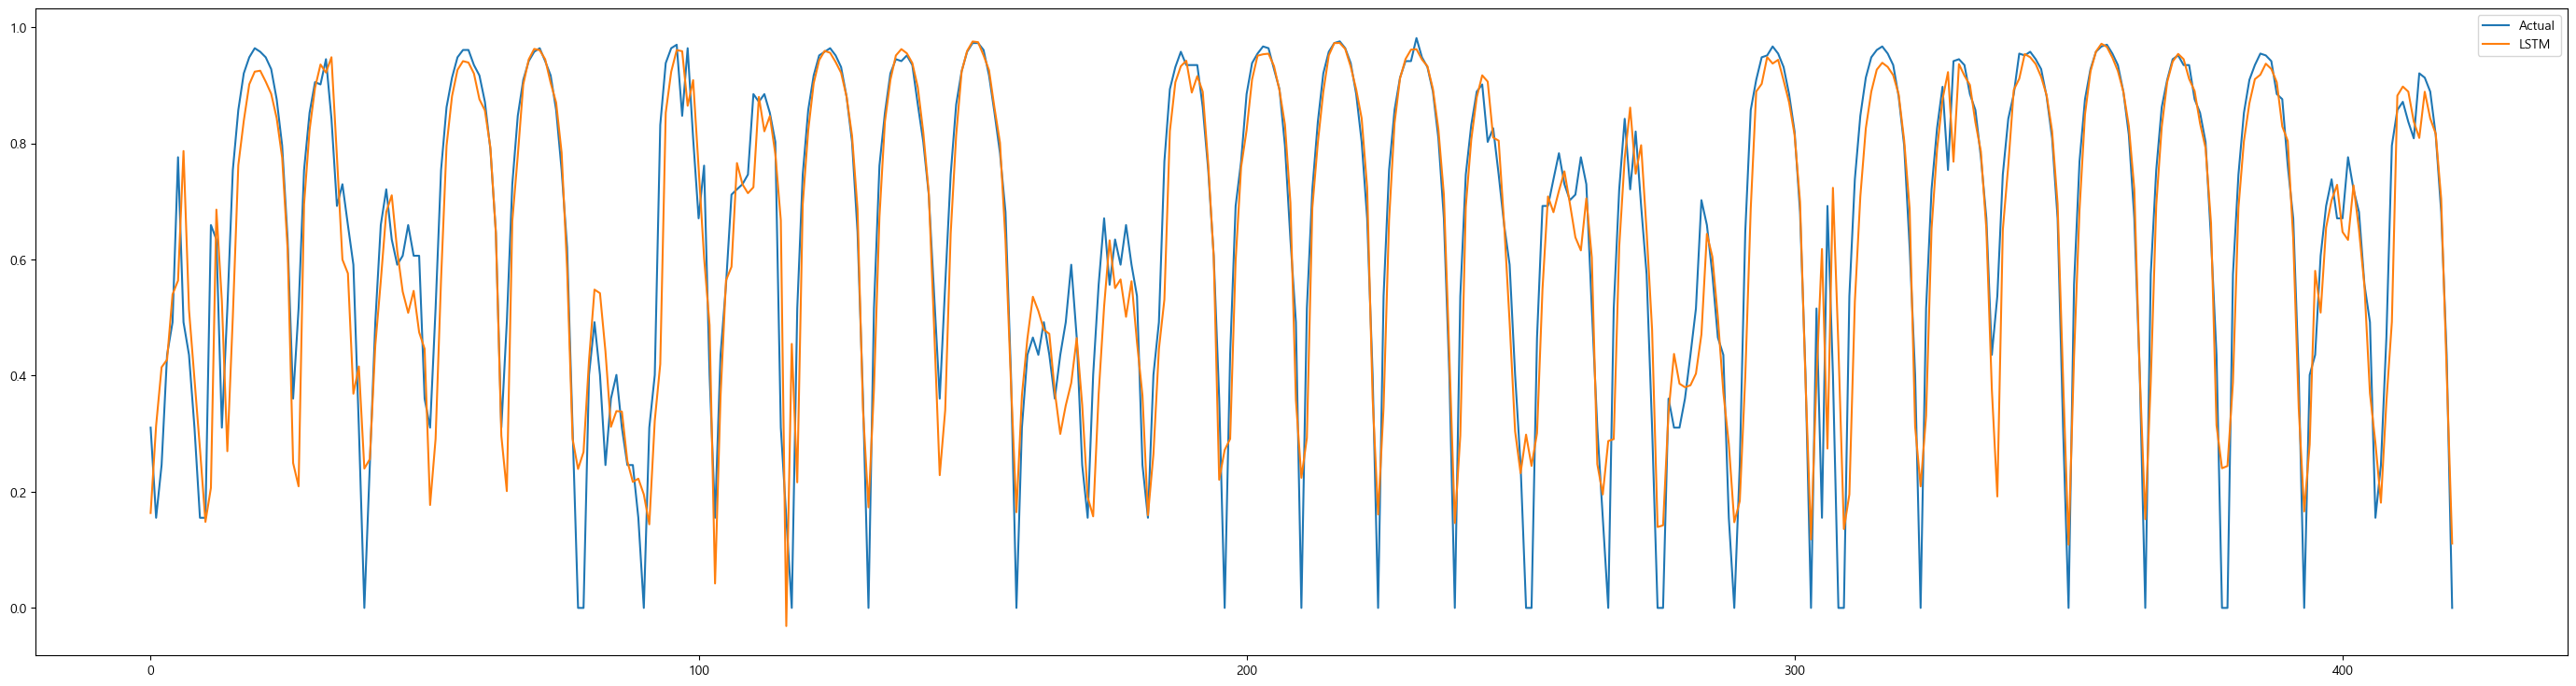

,Results
RMSE,0.117351
R2,0.802669


In [56]:
RMSE = np.sqrt(mean_squared_error(predict_result['Pred'], predict_result['GT']))
R2 = r2_score(predict_result['Pred'], predict_result['GT'])

# 예측 데이터 시각화 
from sklearn.metrics import  mean_squared_error, r2_score

plt.figure(figsize=(35, 9))
plt.plot(predict_result['GT'], label='Actual')
plt.plot(predict_result['Pred'], label='LSTM')
plt.legend()
plt.show()

result = pd.DataFrame(data=[RMSE, R2], index=['RMSE','R2'],columns=['Results'])
result


Evaluate

In [57]:
y_pred = model.predict(dataset_lst_1[2][0])
y_test = np.squeeze(dataset_lst_1[2][1])

y_test_or = np.zeros(shape=(y_test.shape[0], len(features) + 1))
y_pred_lstm = np.zeros(shape=(y_pred.shape[0], len(features) + 1))

y_test_or[:, -1] = y_test
y_pred_lstm[:, -1] = y_pred[:, 0]

# Inverse Transform
y_test_sc_bi = target_scaler_1.inverse_transform(y_test_or)[:, -1]
y_pred_sc_bi = target_scaler_1.inverse_transform(y_pred_lstm)[:, -1]



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [58]:
# 데이터 프레임 만들기 
predict_result = pd.DataFrame()
predict_result['GT'] = y_test_sc_bi 
predict_result['Pred'] = y_pred_sc_bi 

In [59]:
# # 로그 역변환 
y_test_np_log = 10 **  y_test_sc_bi  
y_pred_np_log  = 10 **y_pred_sc_bi 

# 데이터 프레임 만들기 
predict_result = pd.DataFrame()
predict_result['GT'] = y_test_np_log 
predict_result['Pred'] = y_pred_np_log 

In [60]:
predict_result 

,GT,Pred
0,4.0,2.074758
1,2.0,4.064385
2,3.0,6.364054
3,7.0,6.747133
4,9.0,11.142224
...,...,...
416,53.0,43.107940
417,38.0,38.328219
418,21.0,23.227908
419,7.0,6.126201


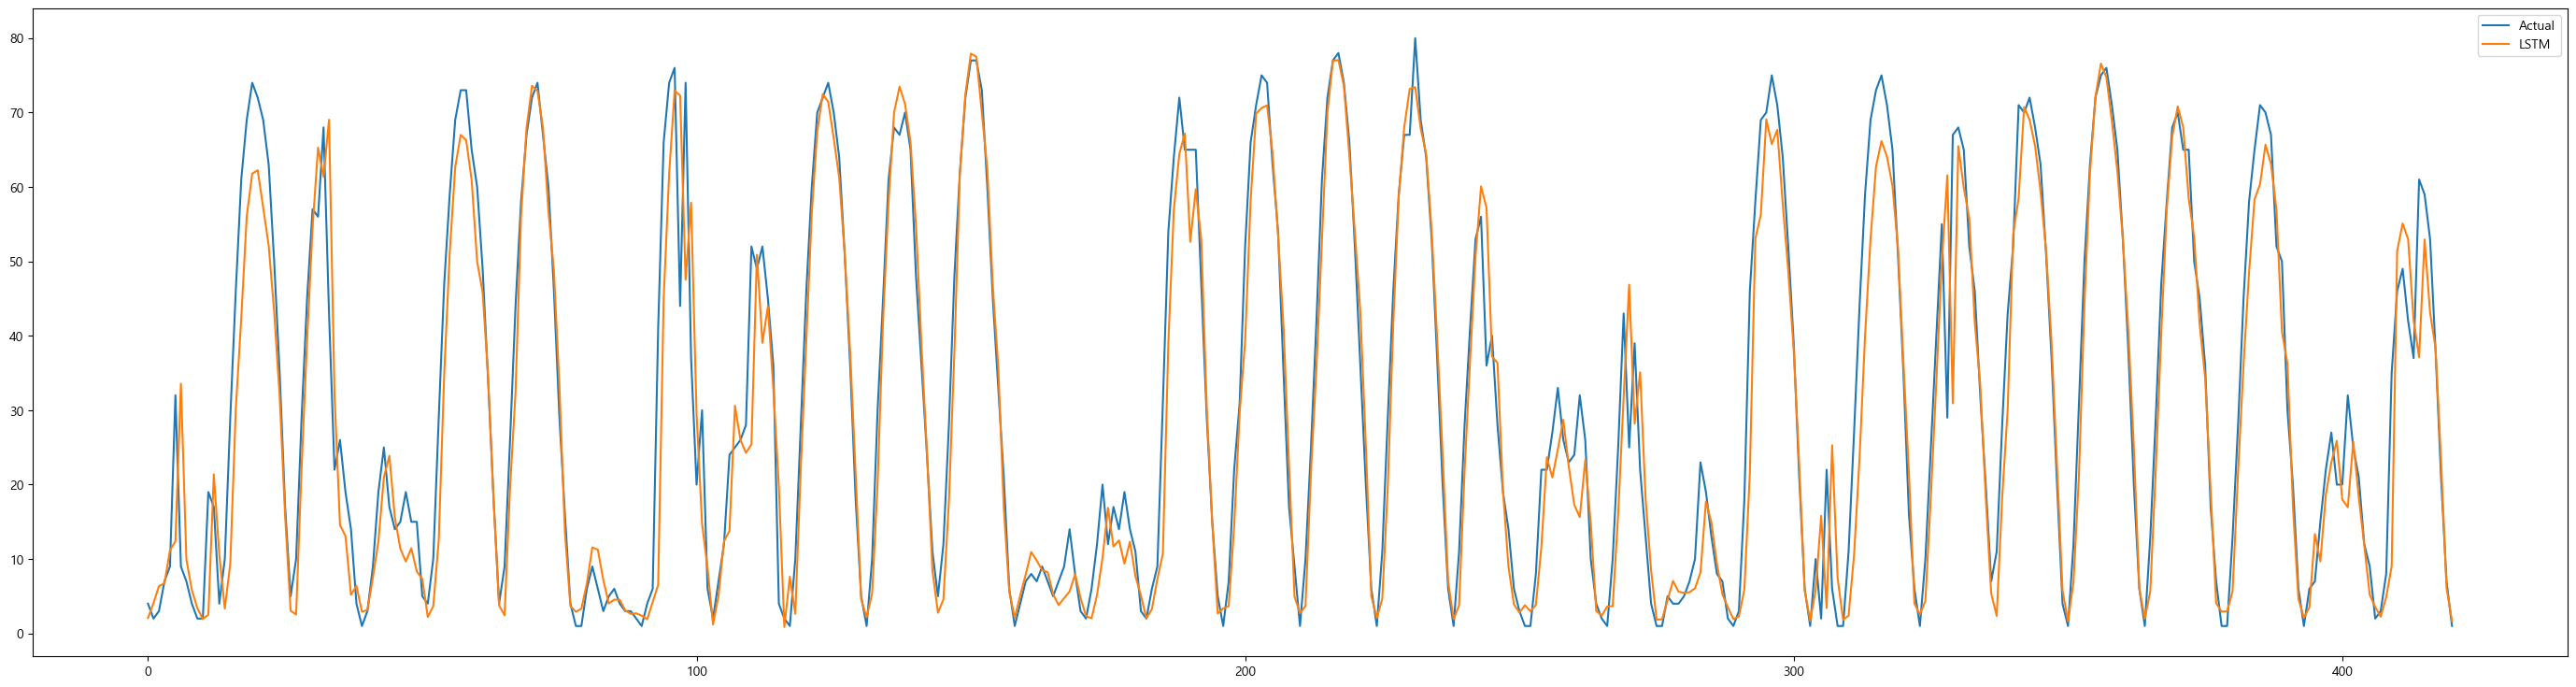

,Results
MAPE,38.874085
RMSE,7.981373
R2,0.892406


In [61]:
MAPE = np.mean(np.abs((predict_result['GT'] - predict_result['Pred']) /  predict_result['GT'])) * 100
RMSE = np.sqrt(mean_squared_error(predict_result['Pred'], predict_result['GT']))
R2 = r2_score(predict_result['Pred'], predict_result['GT'])

# 예측 데이터 시각화 
from sklearn.metrics import  mean_squared_error, r2_score

plt.figure(figsize=(35, 9))
plt.plot(predict_result['GT'], label='Actual')
plt.plot(predict_result['Pred'], label='LSTM')
plt.legend()
plt.show()

result = pd.DataFrame(data=[MAPE, RMSE, R2], index=['MAPE','RMSE','R2'],columns=['Results'])
result


모델 저장 

In [27]:
#with open('./[CIDI] 환경설정/Model(DL)/LSTM/cnn_Bidirectional_model/feature_scaler_' + str('seasonal_add') + '.pkl', 'wb') as f:
#            pickle.dump(feature_scaler_1, f)    
#with open('./[CIDI] 환경설정/Model(DL)/LSTM/cnn_Bidirectional_model/target_scaler.pkl', 'wb') as f:
#            pickle.dump(target_scaler_1, f)    
#model.save('./[CIDI] 환경설정/Model(DL)/LSTM/cnn_Bidirectional_model/cnn_Bidirectional_model.keras')